In [1]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 99

## Initial Exploration

In [2]:
preview = pd.read_csv('../datasets/loans_2007.csv', nrows=5)
preview

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens
0,1077501,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
1,1077430,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
2,1077175,1313524.0,2400.0,2400.0,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
3,1076863,1277178.0,10000.0,10000.0,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0
4,1075358,1311748.0,3000.0,3000.0,3000.0,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,15.0,0.0,27783.0,53.9%,38.0,f,461.73,461.73,3581.120000,3581.12,2538.27,1042.85,0.00,0.00,0.00,Jun-2016,67.79,Jun-2016,0.0,1.0,INDIVIDUAL,0.0,0.0,0.0,0.0,0.0


By looking at the first 5 rows, there are a number of quility issues that can be addressed, as well as optimizations to datatypes that can be made. 
- The `title` column has inconsistent capitalization
- The `term` column can be converted to an integer number of months
- Several columns of floats can be converted to integers.
- The `emp_title` column has some missing data in the form of NaN

Let's split the dataset into chunks and evaluate the size of each one. We can do this by making a histogram of the distribution of chunk sizes in MB. For this exercise, I am limiting my theoretical memory to 10MB. This means the chunk sizes should be about 5MB each. By setting a chunk size of 3000, we are able to achieve this. 

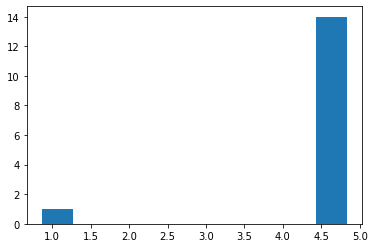

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
memory_footprints = []

chunk_iter = pd.read_csv('../datasets/loans_2007.csv', chunksize=3000)
for chunk in chunk_iter:
    memory_footprints.append(chunk.memory_usage(deep=True).sum()/(1024*1024))
fig = plt.hist(memory_footprints)

Let's see how many numeric and string columns there are.

In [4]:
numeric = []
string = []
chunk_iter = pd.read_csv('../datasets/loans_2007.csv', chunksize=3000)
for chunk in chunk_iter:
    numeric.append(chunk.select_dtypes(include=[np.number]).shape[1])
    string.append(chunk.select_dtypes(include=['object']).shape[1])
print(numeric)
print(string)

[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 30, 30]
[21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22]


For each chunk, there are approximately 31 numeric columns, and 21 string columns, however these are not consistent throughout the dataset. 

In [5]:
string_columns = None
chunk_iter = pd.read_csv('../datasets/loans_2007.csv', chunksize=3000)
for chunk in chunk_iter:
    chunk_strings = set(chunk.select_dtypes(include=['object']).columns.tolist())
    if not string_columns: # populate string columns on first chunk
        string_columns = set(chunk_strings)
        
    diff = chunk_strings - string_columns
    print(diff)

set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
set()
{'id'}
{'id'}


It seems the `id` column is changing type throughout the dataset. We can ignore this column as it is not relevant to our analysis. 

## String Columns Observations
We can convert the string datatypes to a category. This saves space when fewer than half of the total elements are unique. 

In [6]:
chunk_iter = pd.read_csv('../datasets/loans_2007.csv', chunksize=3000)
unique_counts = {}
for chunk in chunk_iter:
    strings = chunk.select_dtypes(include=['object'])
    cols = strings.columns
    for c in cols:
        val_counts = strings[c].value_counts()
        if c in unique_counts:
            unique_counts[c].append(val_counts)
        else:
            unique_counts[c] = [val_counts]
        
combined_unique = {}
for col in unique_counts:
    unique_concat = pd.concat(unique_counts[col])
    unique_group = unique_concat.groupby(unique_concat.index).sum()
    percentage_unique = len(unique_group) / sum(unique_group) * 100
    combined_unique[col] = {'column':col, 'unique count':len(unique_group), 'percentage':np.round(percentage_unique,2)}
    print(combined_unique[col])


{'column': 'term', 'unique count': 2, 'percentage': 0.0}
{'column': 'int_rate', 'unique count': 394, 'percentage': 0.93}
{'column': 'grade', 'unique count': 7, 'percentage': 0.02}
{'column': 'sub_grade', 'unique count': 35, 'percentage': 0.08}
{'column': 'emp_title', 'unique count': 30658, 'percentage': 76.82}
{'column': 'emp_length', 'unique count': 11, 'percentage': 0.03}
{'column': 'home_ownership', 'unique count': 5, 'percentage': 0.01}
{'column': 'verification_status', 'unique count': 3, 'percentage': 0.01}
{'column': 'issue_d', 'unique count': 55, 'percentage': 0.13}
{'column': 'loan_status', 'unique count': 9, 'percentage': 0.02}
{'column': 'pymnt_plan', 'unique count': 2, 'percentage': 0.0}
{'column': 'purpose', 'unique count': 14, 'percentage': 0.03}
{'column': 'title', 'unique count': 21264, 'percentage': 50.01}
{'column': 'zip_code', 'unique count': 837, 'percentage': 1.97}
{'column': 'addr_state', 'unique count': 50, 'percentage': 0.12}
{'column': 'earliest_cr_line', 'uniqu

We can see now that there are 18 columns that have unique percentages below 50%. 

## Numeric Columns Observations
Let's check for missing values in each of the numeric columns

In [7]:
chunk_iter = pd.read_csv('../datasets/loans_2007.csv', chunksize=3000)
missing_values = {}
for chunk in chunk_iter:
    numeric = chunk.select_dtypes(include=['float'])
    cols = numeric.columns
    for c in cols:
        missing_count = numeric[c].isnull().sum()
        if c in unique_counts:
            missing_values[c].append(missing_count)
        else:
            missing_values[c] = [missing_count]
missing_values

{'member_id': [2],
 'loan_amnt': [2],
 'funded_amnt': [2],
 'funded_amnt_inv': [2],
 'installment': [2],
 'annual_inc': [6],
 'dti': [2],
 'delinq_2yrs': [31],
 'inq_last_6mths': [31],
 'open_acc': [31],
 'pub_rec': [31],
 'revol_bal': [2],
 'total_acc': [31],
 'out_prncp': [2],
 'out_prncp_inv': [2],
 'total_pymnt': [2],
 'total_pymnt_inv': [2],
 'total_rec_prncp': [2],
 'total_rec_int': [2],
 'total_rec_late_fee': [2],
 'recoveries': [2],
 'collection_recovery_fee': [2],
 'last_pymnt_amnt': [2],
 'collections_12_mths_ex_med': [91],
 'policy_code': [2],
 'acc_now_delinq': [31],
 'chargeoff_within_12_mths': [91],
 'delinq_amnt': [31],
 'pub_rec_bankruptcies': [512],
 'tax_liens': [68]}

Because there are no numeric columns that aren't missing data, we cannot convert any column data types to Integers, since integers do not support missing values. It might be possible to remove the rows with missing data, but this could comprimise the completeness of the dataset. We will leave the numeric columns as float datatypes. 

## Total Memory Usage 
Let's calculate the total memory usage for each chunk, and sum them to get the total memory usage. 

In [8]:
chunk_iter = pd.read_csv('../datasets/loans_2007.csv', chunksize=3000)
bytes_used = 0
for chunk in chunk_iter:
    bytes_used += chunk.memory_usage(deep=True).sum()
mb_used = bytes_used / (2**20)
print(f'{round(mb_used, 2)} MB used in total')

65.24 MB used in total


## Applying Optimizations
The greatest memory improvements come from string columns. We'll only consider the useful columns. The `term` and `int_rate` columns are represented as strings. These can be converted to float types after extracting the numeric portions. We can also optimie the 18 columns we found earlier that are better suited as category datatypes.

In [9]:
useful_obj_cols = ['term', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'issue_d', 'purpose', 'earliest_cr_line', 'revol_util', 'last_pymnt_d', 'last_credit_pull_d']


In [10]:
category_dtypes = {'sub_grade': 'category', 'home_ownership': 'category', 'verification_status': 'category', 'purpose': 'category'}
chunk_iter = pd.read_csv('../datasets/loans_2007.csv', chunksize=3000, dtype=category_dtypes)
mb_used = 0
for chunk in chunk_iter:
    term_cleaned = chunk['term'].str.rstrip(" months")
    revol_cleaned = chunk['revol_util'].str.rstrip("%")
    chunk['term'] = pd.to_numeric(term_cleaned)
    chunk['revol_util'] = pd.to_numeric(revol_cleaned)
    mb_used += chunk.memory_usage(deep=True).sum() / (2**20)
chunk.dtypes
print(f'{round(mb_used, 2)} MB after optimizations. An improvement of {round((1- (mb_used / 65.24)) * 100)}%.')
               

50.33 MB after optimizations. An improvement of 23%.
